In [10]:
import pandas as pd

file_url = 'https://raw.githubusercontent.com/sakrelie/capstone-project-dataset-on-net-production-of-energy/main/summary%20-%20net%20production.xlsx'

# Load the data from the "Summary" sheet, specifying the engine
data = pd.read_excel(file_url, sheet_name='Summary', engine='openpyxl')

# Display the first few rows to check the data
print(data.head())

     Year month  Day  Net production
0  2018.0     1  1.0   872537.226096
1  2018.0     1  2.0   869609.622510
2  2018.0     1  3.0   848288.416611
3  2018.0     1  4.0   816861.867724
4  2018.0     1  5.0   870009.814627






*  1- Creates a 'Date' column from 'Year', 'month', and 'Day'. Removes rows where the date parsing failed, then sets 'Date' as the index, and drops the original columns.

* 2- Extends the dataset to include all dates up to today's date, filling missing dates with NaN values.

*  3- Calculates a rolling mean and standard deviation for the 'Net production' column using a 30-day window.

*  4- Identifies dates with missing 'Net production' values. If rolling statistics are unavailable, it falls back on the overall mean and standard deviation to generate random values to fill gaps.


* 5-Linearly interpolates any remaining NaN values in 'Net production' and backfills any leftover gaps.


* 6- Removes the temporary rolling statistics columns and displays the last few rows to preview the cleaned data.




In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

file_url = 'https://raw.githubusercontent.com/sakrelie/capstone-project-dataset-on-net-production-of-energy/main/summary%20-%20net%20production.xlsx'

# Load the data from the "Summary" sheet
data = pd.read_excel(file_url, sheet_name='Summary', engine='openpyxl')

# Convert to datetime and clean data
data['Date'] = pd.to_datetime(data[['Year', 'month', 'Day']], errors='coerce')
data.dropna(subset=['Date'], inplace=True)
data.set_index('Date', inplace=True)
data.drop(columns=['Year', 'month', 'Day'], inplace=True)

# Fill in dates up to today's date
today = pd.to_datetime('today')
full_date_range = pd.date_range(start=data.index.min(), end=today, freq='D')
data = data.reindex(full_date_range)

# Decompose the time series to extract trend, seasonality, and residuals
decomposition = seasonal_decompose(data['Net production'].dropna(), model='additive', period=365)
data['Trend'] = decomposition.trend
data['Seasonal'] = decomposition.seasonal
data['Residual'] = decomposition.resid

# Interpolate the trend for missing values
data['Trend'].interpolate(method='linear', inplace=True)
data['Trend'].fillna(method='bfill', inplace=True)

# Fill missing seasonal values by repeating the seasonal pattern
seasonal_cycle = data['Seasonal'].dropna().iloc[:365]  # Assume yearly seasonality pattern
extended_seasonal = pd.concat([seasonal_cycle] * (len(data) // 365 + 1), ignore_index=True)[:len(data)]
data['Seasonal'] = extended_seasonal.values

# Calculate the new 'Net production' using the interpolated trend and repeated seasonality
data['Net production'] = data['Net production'].combine_first(data['Trend'] + data['Seasonal'])

# Clean up by dropping intermediate columns
data.drop(columns=['Trend', 'Seasonal', 'Residual'], inplace=True)

# Preview the corrected data
print(data.tail())


            Net production
2024-11-18   703345.297703
2024-11-19   688641.692098
2024-11-20   702781.877477
2024-11-21   724162.711161
2024-11-22   682783.851170


<ipython-input-11-3598684accc5>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Trend'].interpolate(method='linear', inplace=True)
<ipython-input-11-3598684accc5>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'



* Imports matplotlib.pyplot for creating visualizations.

* Creates a figure of size 14x6 inches.
* Plots the 'Net production' data from your DataFrame to visualize the time series

* Adds labels and a title to the plot for better understanding.
* Displays the plot to show how 'Net Production' changes over time.









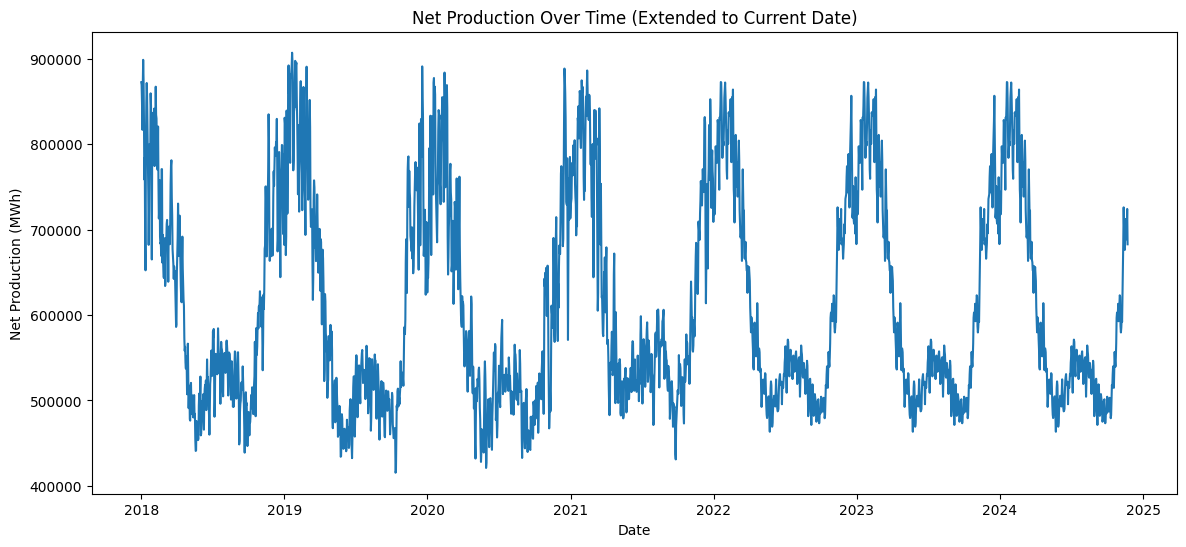

In [12]:
import matplotlib.pyplot as plt

# Plot the full time series of Net Production
plt.figure(figsize=(14, 6))
plt.plot(data['Net production'])
plt.title('Net Production Over Time (Extended to Current Date)')
plt.xlabel('Date')
plt.ylabel('Net Production (MWh)')
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3qq03dlz/uyzxa243.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3qq03dlz/tz94j5by.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51418', 'data', 'file=/tmp/tmp3qq03dlz/uyzxa243.json', 'init=/tmp/tmp3qq03dlz/tz94j5by.json', 'output', 'file=/tmp/tmp3qq03dlz/prophet_modelh114_gpf/prophet_model-20241122044304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:43:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:43:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


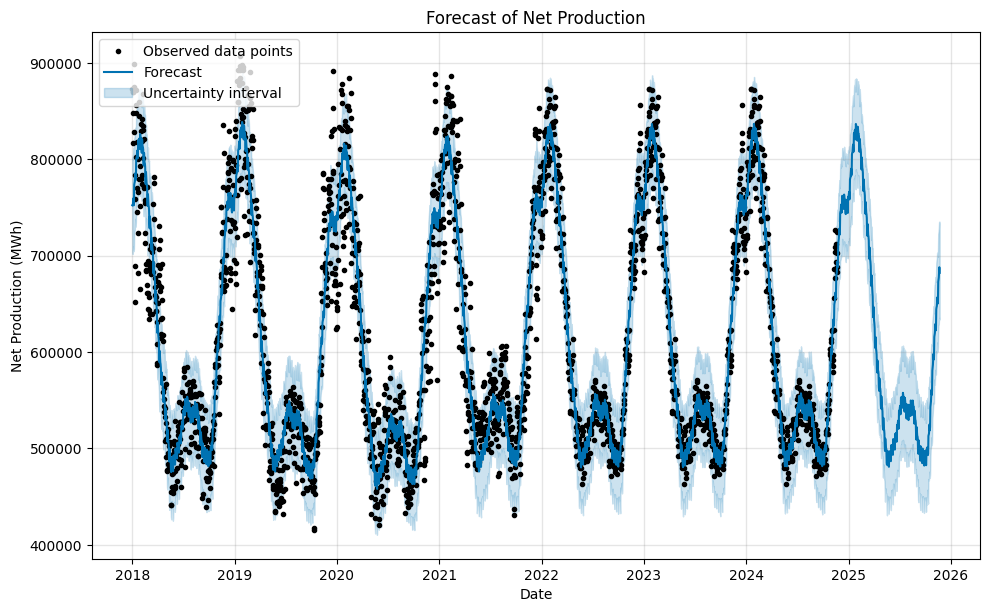

In [13]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = data.reset_index().rename(columns={'index': 'ds', 'Net production': 'y'})

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Extend the prediction to a future date
future_periods = 365  # Change to any future period length you want
future = prophet_model.make_future_dataframe(periods=future_periods)
forecast = prophet_model.predict(future)

# Plot the forecasted data
fig = prophet_model.plot(forecast)
plt.title('Forecast of Net Production')
plt.xlabel('Date')
plt.ylabel('Net Production (MWh)')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 27921.7047712177, RMSE: 37909.82329742151


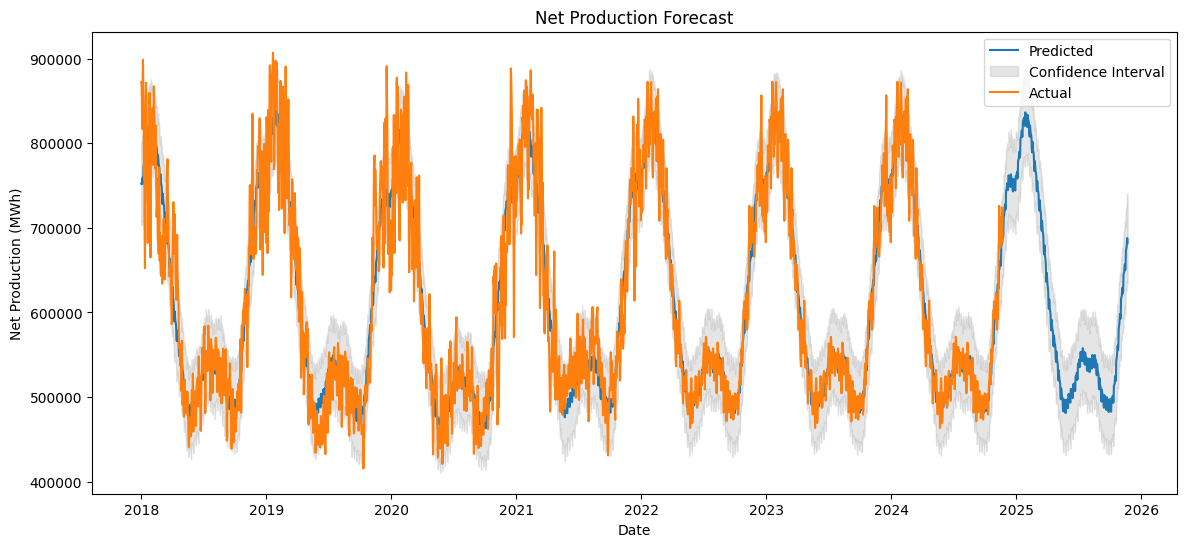

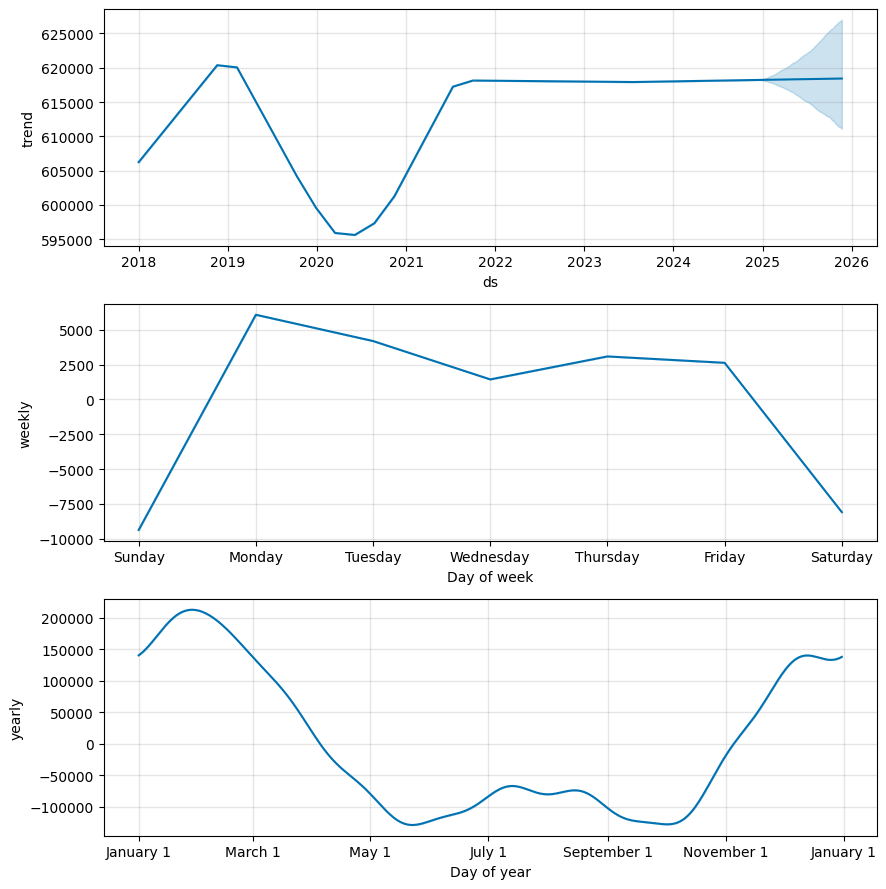

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = prophet_data['y']
y_pred = forecast['yhat'][:len(y_true)]  # Predictions for the historical period

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
# ... (calculate other metrics)

print(f"MAE: {mae}, RMSE: {rmse}")

plt.figure(figsize=(14, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted') # Removed extra indentation (4 spaces)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual')
plt.title('Net Production Forecast')
plt.xlabel('Date')
plt.ylabel('Net Production (MWh)')
plt.legend()
plt.show()
fig2 = prophet_model.plot_components(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 124968.15113885733
MSE: 15617038799.064287


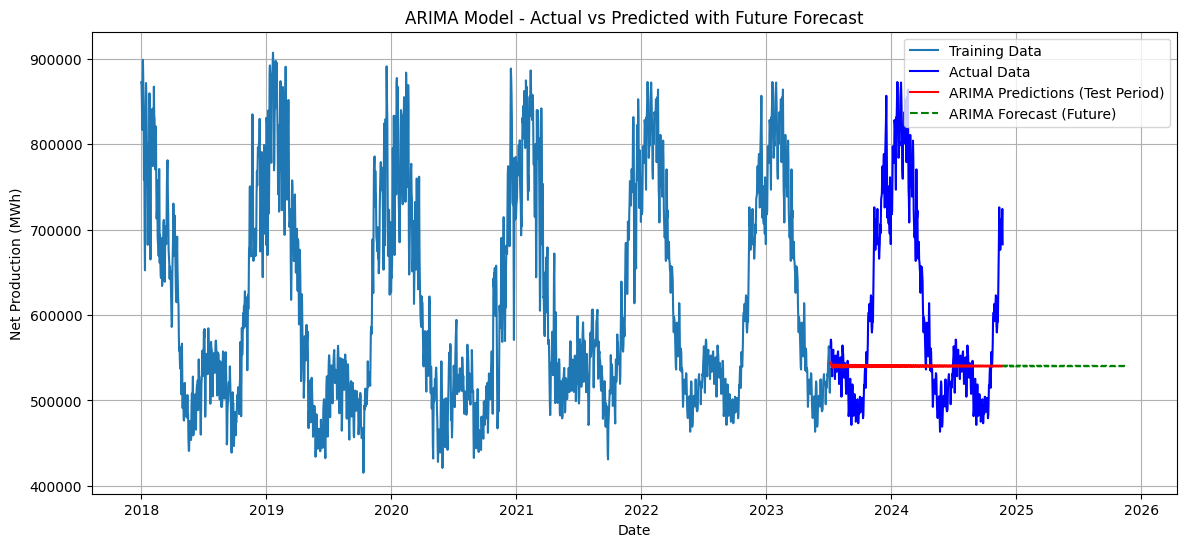

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Define train and test sets (using 80% training, 20% testing)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit an ARIMA model - Adjust the order parameters for better accuracy
arima_model = ARIMA(train['Net production'], order=(5, 1, 5))  # Adjust (p, d, q) as needed
arima_result = arima_model.fit()

# Forecast for the test period and the future (e.g., 365 days ahead)
test_steps = len(test)
future_steps = 365  # Predicting 365 days into the future
total_steps = test_steps + future_steps

# Extend the forecast
forecast = arima_result.get_forecast(steps=total_steps)
forecast_index = pd.date_range(start=test.index.min(), periods=total_steps, freq='D')
forecast_values = forecast.predicted_mean

# Calculate RMSE and MSE on the test period
predictions_test = forecast_values[:test_steps]
rmse = np.sqrt(mean_squared_error(test['Net production'], predictions_test))
mse = mean_squared_error(test['Net production'], predictions_test)
print(f'RMSE: {rmse}')
print(f'MSE: {mse}')

# Plot the results
plt.figure(figsize=(14, 6))

# Plot historical actual and predicted values
plt.plot(train.index, train['Net production'], label='Training Data')
plt.plot(test.index, test['Net production'], label='Actual Data', color='blue')
plt.plot(test.index, predictions_test, label='ARIMA Predictions (Test Period)', color='red')

# Plot future predictions
future_dates = forecast_index[test_steps:]
future_values = forecast_values[test_steps:]
plt.plot(future_dates, future_values, label='ARIMA Forecast (Future)', color='green', linestyle='dashed')

# Visualization settings
plt.title('ARIMA Model - Actual vs Predicted with Future Forecast')
plt.xlabel('Date')
plt.ylabel('Net Production (MWh)')
plt.legend()
plt.grid(True)
plt.show()


Plotted the data to see if its stationary meaning that it holds the same pattern which means its good

<Axes: title={'center': 'Differenced Data for Stationarity Check'}>

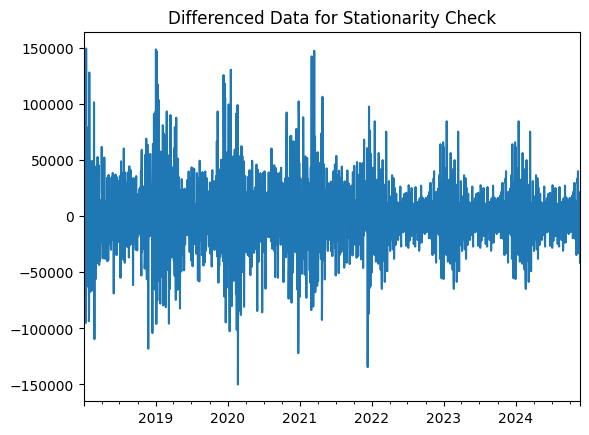

In [17]:
# Differencing the data to make it stationary (first difference)
data_diff = data['Net production'].diff().dropna()

# Plot the differenced data to see if it's stationary
data_diff.plot(title='Differenced Data for Stationarity Check')

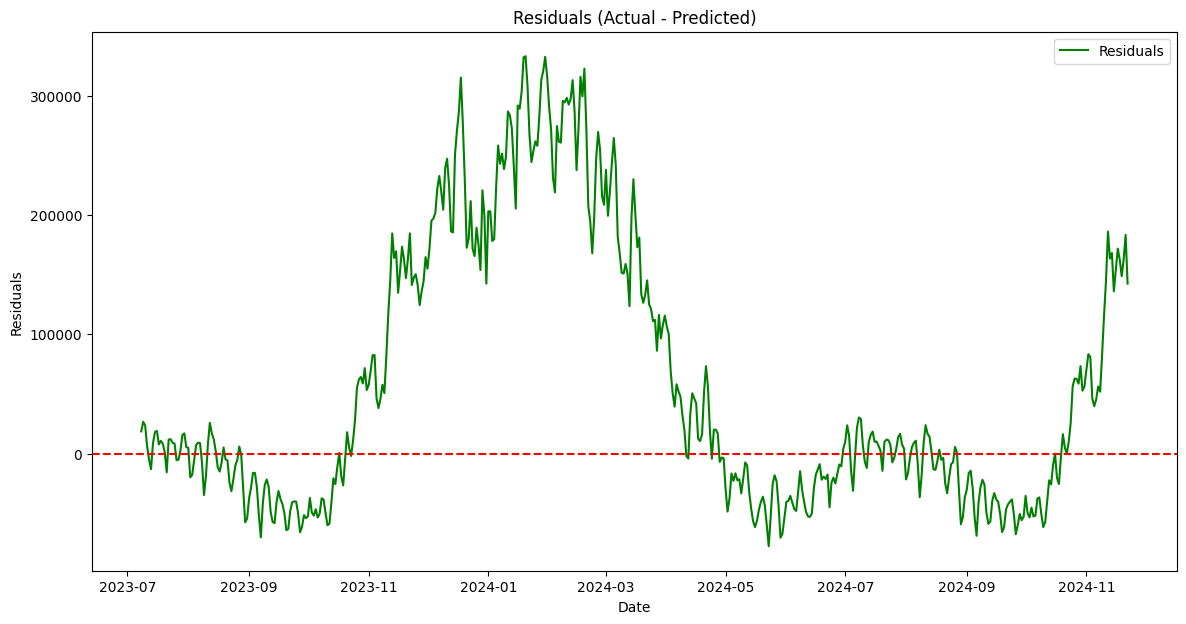

Residuals Summary:
count       504.000000
mean      57815.791900
std      110899.843724
min      -77745.408241
25%      -26133.733452
50%        9039.355289
75%      147879.520710
max      333258.338265
dtype: float64


In [19]:
test_data = test  # Assign 'test' to 'test_data'

# Get predictions for the test period from the ARIMA model
predictions = arima_result.predict(start=test_data.index.min(), end=test_data.index.max())


# Calculate residuals
residuals = test_data['Net production'] - predictions

# Plot residuals to check if they're random (a sign of a good model)
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, residuals, label='Residuals', color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

# Summary statistics for residuals
print('Residuals Summary:')
print(residuals.describe())